# Import Modules

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

# Read and Convert

In [38]:
df = pd.read_csv("BTC-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-29,2567.560059,2588.830078,2510.479980,2539.320068,2539.320068,949979008
1,2017-06-30,2539.239990,2559.250000,2478.429932,2480.840088,2480.840088,860273024
2,2017-07-01,2492.600098,2515.270020,2419.229980,2434.550049,2434.550049,779913984
3,2017-07-02,2436.399902,2514.280029,2394.840088,2506.469971,2506.469971,803747008
4,2017-07-03,2498.560059,2595.000000,2480.469971,2564.060059,2564.060059,964112000


In [39]:
df1 = df.reset_index()['Close']

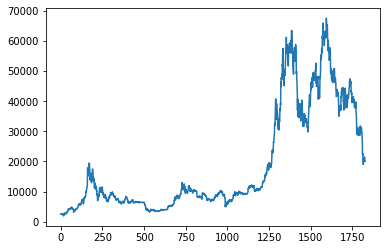

In [40]:
plt.plot(df1)

In [41]:
scaler=MinMaxScaler(feature_range=(-1,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [42]:
df1.size

1827

# Transform Train and test dataset

In [43]:

training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [44]:
train_data.size, test_data.size

(1461, 366)

In [45]:

def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [46]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [47]:
y_train.shape

(1360,)

In [48]:
X_train = np.expand_dims(X_train, axis=2)
y_train = np.expand_dims(y_train, axis=1)
X_test = np.expand_dims(X_test, axis=2)
y_test = np.expand_dims(y_test, axis=1)

In [49]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [50]:
y_train.size(),X_train.size()

(torch.Size([1360, 1]), torch.Size([1360, 100, 1]))

In [51]:
X_train.shape

torch.Size([1360, 100, 1])

# Building model

In [52]:

input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        return out
    


In [53]:

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


# Train Model

In [ ]:
# Train model
#####################
num_epochs = 1000
look_back = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

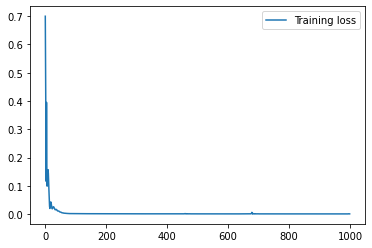

In [55]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [56]:
np.shape(y_train_pred)

torch.Size([1360, 1])

# Test Model

In [57]:
train_predict=model(X_train)
test_predict=model(X_test)

In [58]:
train_predict=scaler.inverse_transform(train_predict.detach().numpy())
test_predict=scaler.inverse_transform(test_predict.detach().numpy())

In [59]:
y_test=scaler.inverse_transform(y_test.detach().numpy())

In [65]:
y_train = scaler.inverse_transform(y_train.detach().numpy())

In [66]:
t_val = 0
for i in range(len(test_predict)):
  t_val += ((train_predict[i]/ y_train[i]) - 1) * ((train_predict[i]/ y_train[i]) - 1)
  #print(test_predict[i], y_te[i])
math.sqrt(t_val/ len(train_predict))

0.026588096233319158

In [67]:
t_val = 0
for i in range(len(test_predict)):
  t_val += ((test_predict[i]/ y_test[i]) - 1) * ((test_predict[i]/ y_test[i]) - 1)
  #print(test_predict[i], y_test[i])
math.sqrt(t_val/ len(test_predict))

0.04946727384933073

In [61]:
math.sqrt(mean_squared_error(y_test,test_predict))

1867.8557224796566

# Data Visuvalize

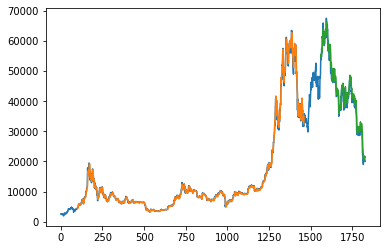

In [62]:
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Save Model

In [63]:
PATH = 'lstm.pt'
torch.save(model.state_dict(), PATH)

In [64]:
model.load_state_dict(torch.load('/content/lstm.pt'))
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)